In [1]:
import pandas as pd
import geopandas as gpd
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, SAGEConv
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import haversine_distances
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [2]:
CUDA = True
device = "cuda" if (torch.cuda.is_available() and CUDA) else "cpu"

In [3]:
#load and clean
node_df = pd.read_csv("data/node_features.csv")
road_gdf = gpd.read_file("data/singapore_road_network.gpkg", layer="edges")

node_df = node_df.drop(columns=[col for col in node_df.columns if "Unnamed" in col])
node_df = node_df.dropna()
coords = node_df[['Latitude', 'Longitude']].to_numpy()
coords_rad = np.radians(coords)
distances = haversine_distances(coords_rad) * 6371000  # in meters

# Define connectivity threshold (in meters)
edge_index = np.array(np.where((distances > 0) & (distances < 1000)))
edge_attr = distances[edge_index[0], edge_index[1]]

# Node features
node_df = node_df.rename(columns={
    'Total Casualties Fatalities': 'Total_Casualties_Fatalities',
    'Pedestrians': 'Pedestrians',
    'Rainfall_mm': 'Rainfall',
    'Traffic_Volume': 'Traffic_Volume'
})

# Pick the clean features we can use
feature_cols = [
    'Rainfall',
    'Traffic_Volume',
    'Total_Casualties_Fatalities',
    'Pedestrians'
]
node_df.columns = node_df.columns.str.strip()
features = node_df[feature_cols].astype(float).to_numpy()
scaler = StandardScaler()
x = torch.tensor(scaler.fit_transform(features), dtype=torch.float)

# Binary labels: hotspot or not
threshold = node_df['Total_Casualties_Fatalities'].astype(float).median()
y = torch.tensor((node_df['Total_Casualties_Fatalities'].astype(float) > threshold).astype(int).values, dtype=torch.long)

data = Data(
    x=x,
    edge_index=torch.tensor(edge_index, dtype=torch.long),
    edge_attr=torch.tensor(edge_attr, dtype=torch.float),
    y=y
)

In [4]:
print(node_df.columns.tolist())

['Latitude', 'Longitude', 'Date', 'Rainfall', 'Traffic_Volume', 'Total_Casualties_Fatalities', 'Pedestrians', 'Personal Mobility Device Users', 'Cyclists & Pillions', 'Motor Cyclists & Pillion Riders', 'Motor Cars And Station Wagons', 'Goods Vans & Pick-Ups', 'Goods Vans', 'Pick-Ups', 'Lorries, Tipper Trucks & Trailers', 'Lorries', 'Tipper Trucks', 'Trailers', 'Buses', 'Others', 'Total Casualties Injured', 'Pedestrians.1', 'Personal Mobility Device Users.1', 'Cyclists & Pillions.1', 'Motor Cyclists & Pillion Riders.1', 'Motor Cars And Station Wagons.1', 'Goods Vans & Pick-Ups.1', 'Goods Vans.1', 'Pick-Ups.1', 'Lorries, Tipper Trucks & Trailers.1', 'Lorries.1', 'Tipper Trucks.1', 'Trailers.1', 'Buses.1', 'Others.1', 'Total Casualties Fatalities_casualty', 'Pedestrians_casualty', 'Personal Mobility Device Users_casualty', 'Cyclists & Pillions_casualty', 'Motor Cyclists & Pillion Riders_casualty', 'Motor Cars And Station Wagons_casualty', 'Goods Vans & Pick-Ups_casualty', 'Goods Vans_casu

In [ ]:
#train test split
num_nodes = data.num_nodes

# Create indices for splitting
all_indices = np.arange(num_nodes)
train_idx, test_idx = train_test_split(all_indices, test_size=0.2, random_state=42, stratify=data.y.cpu().numpy())
train_idx, val_idx = train_test_split(train_idx, test_size=0.25, random_state=42, stratify=data.y[train_idx].cpu().numpy())

data.train_mask = torch.zeros(num_nodes, dtype=torch.bool)
data.val_mask = torch.zeros(num_nodes, dtype=torch.bool)
data.test_mask = torch.zeros(num_nodes, dtype=torch.bool)

data.train_mask[train_idx] = True
data.val_mask[val_idx] = True
data.test_mask[test_idx] = True

In [8]:
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv

class GCN_SAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN_SAGE, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)
        self.dropout = 0.5

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return x


In [ ]:
# Early stopping implementation
early_stopping_patience = 10  # Number of epochs with no improvement to wait before stopping
best_val_loss = float('inf')  # Initialize best validation loss as infinity
epochs_without_improvement = 0  # Counter for epochs without improvement

# Training loop
model = GCN_SAGE(data.num_node_features, 32, 2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
loss_fn = torch.nn.CrossEntropyLoss()

for epoch in range(1, 101):
    model.train()
    optimizer.zero_grad()

    out = model(data.x, data.edge_index)
    loss = loss_fn(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

    # Evaluation mode for accuracy and validation loss
    model.eval()
    with torch.no_grad():
        pred = out.argmax(dim=1)

        # Calculate training accuracy
        train_correct = (pred[data.train_mask] == data.y[data.train_mask]).sum().item()
        train_acc = train_correct / data.train_mask.sum().item()

        # Calculate validation accuracy and loss
        val_correct = (pred[data.val_mask] == data.y[data.val_mask]).sum().item()
        val_acc = val_correct / data.val_mask.sum().item()

        val_loss = loss_fn(out[data.val_mask], data.y[data.val_mask]).item()

    # Print results for the current epoch
    print(f"Epoch {epoch:03d} | Loss: {loss.item():.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f} | Val Loss: {val_loss:.4f}")

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0  # Reset counter if we have improvement
    else:
        epochs_without_improvement += 1

    # Stop training if validation loss hasn't improved for 'patience' epochs
    if epochs_without_improvement >= early_stopping_patience:
        print(f"Early stopping triggered at epoch {epoch}.")
        break


Epoch 001 | Loss: 0.6225 | Train Acc: 0.6094 | Val Acc: 0.6364 | Val Loss: 0.6538
Epoch 002 | Loss: 0.6455 | Train Acc: 0.6250 | Val Acc: 0.5455 | Val Loss: 0.6021
Epoch 003 | Loss: 0.5203 | Train Acc: 0.7969 | Val Acc: 0.8182 | Val Loss: 0.5430
Epoch 004 | Loss: 0.5128 | Train Acc: 0.7344 | Val Acc: 0.7273 | Val Loss: 0.5672
Epoch 005 | Loss: 0.4723 | Train Acc: 0.7969 | Val Acc: 0.9091 | Val Loss: 0.4537
Epoch 006 | Loss: 0.4627 | Train Acc: 0.8438 | Val Acc: 0.8636 | Val Loss: 0.4239
Epoch 007 | Loss: 0.4424 | Train Acc: 0.8438 | Val Acc: 0.8182 | Val Loss: 0.3911
Epoch 008 | Loss: 0.3882 | Train Acc: 0.8750 | Val Acc: 0.8636 | Val Loss: 0.4332
Epoch 009 | Loss: 0.3779 | Train Acc: 0.8750 | Val Acc: 0.9091 | Val Loss: 0.3327
Epoch 010 | Loss: 0.3607 | Train Acc: 0.8594 | Val Acc: 0.9091 | Val Loss: 0.2760
Epoch 011 | Loss: 0.3438 | Train Acc: 0.8906 | Val Acc: 0.9091 | Val Loss: 0.2736
Epoch 012 | Loss: 0.3066 | Train Acc: 0.8906 | Val Acc: 0.9091 | Val Loss: 0.2874
Epoch 013 | Loss

In [17]:
model.eval()
with torch.no_grad():
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)

    val_acc = (pred[data.val_mask] == data.y[data.val_mask]).sum().item() / data.val_mask.sum().item()
    test_acc = (pred[data.test_mask] == data.y[data.test_mask]).sum().item() / data.test_mask.sum().item()

print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

Validation Accuracy: 0.9091
Test Accuracy: 0.8636


NameError: name 'train_losses' is not defined

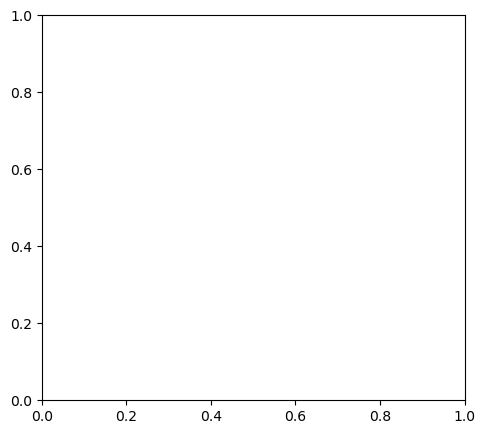

In [ ]:
plt.subplot(1,2,2)
plt.plot(val_accuracies)
plt.title("Validation Accuracy")
plt.show()

from torch_geometric.explain.config import ModelReturnType, Explainer, GNNExplainer
from torch_geometric.explain.config import ModelConfig, ModelMode, ModelTaskLevel, ModelReturnType

print(list(ModelReturnType))

explainer = Explainer(
    model=model,
    algorithm=GNNExplainer(epochs=200),
    explanation_type="model",
    node_mask_type="attributes",
    edge_mask_type="object",
    model_config=ModelConfig(
        mode=ModelMode.multiclass_classification,      
        task_level=ModelTaskLevel.node,    
        return_type=ModelReturnType.raw  
    )
)


# 1. Pick node and explain
node_idx = int(val_idx[0])
explanation = explainer(x=data.x, edge_index=data.edge_index, index=node_idx)

# 2. Get the global flat mask
importance = explanation.node_mask.detach().cpu().numpy().flatten()

# 3. Extract only the part for the current node
num_features = 4
start = node_idx * num_features
end = start + num_features
importance = importance[start:end]  # ✅ extract feature importance for the node

# 4. Plotting
feature_labels = ['Rainfall', 'Traffic Volume', 'Total Casualties', 'Pedestrians']
indices = np.argsort(importance)[::-1]
sorted_importance = importance[indices]
sorted_labels = [feature_labels[int(i)] for i in indices]

import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
bars = plt.barh(range(len(sorted_labels)), sorted_importance, color='skyblue')
plt.yticks(range(len(sorted_labels)), sorted_labels)
plt.gca().invert_yaxis()
plt.xlabel("Importance")
plt.title(f"Feature Importance for Node {node_idx}")
for i, bar in enumerate(bars):
    plt.text(bar.get_width() + 0.01, bar.get_y() + 0.3, f"{sorted_importance[i]:.3f}")
plt.tight_layout()
plt.show()

node_idx = int(val_idx[0])
explanation = explainer(data.x, data.edge_index, index=node_idx)
explanation.visualize_feature_importance()




